# Training U-net model from scratch

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from load_data import ImageDataSet


from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model



## Importing and preparing work directory and data

In [68]:
# Create an instance of the class with the data directory
data_set = ImageDataSet("./../../data")
X_train = data_set.data_train
X_test = data_set.data_test
y_train = data_set.labels_train


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}") # 262144 = 512*512 :)
print(f"X_test shape: {X_test.shape}")

X_train shape: (1000, 512, 512)
y_train shape: (1000, 262144)
X_test shape: (500, 512, 512)


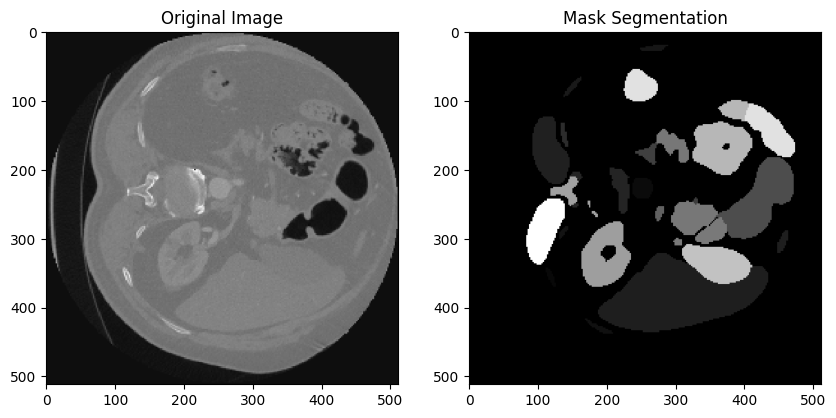

In [94]:
#Choose the scan you want to plot
chosen_scan_to_plot = 99

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(X_train[chosen_scan_to_plot], cmap='gray')
ax1.set_title('Original Image')
ax2.imshow(y_train.iloc[chosen_scan_to_plot].values.reshape((512,512)), cmap='gray')
ax2.set_title('Mask Segmentation')
plt.show()

## Implementing the U-net model

In [4]:
def unet(input_shape=(512, 512, 1), num_classes=2):
    inputs = Input(shape=input_shape)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=sparse_categorical_crossentropy, metrics=['accuracy'])

    return model



In [134]:
model = unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 512, 512, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_23[0][0]']              
                                )                                                           

## Preprocessing

In [10]:
X_train_processed = X_train[:200] 
X_train_processed = np.expand_dims(X_train_processed, axis=-1)

pixel_values = y_train[:200].transpose()
y_train_array = pixel_values.values.reshape(((200, 512, 512, 1)))
# Create a new array with values of 1 where the original array is not 0
y_train_processed = np.where(y_train_array == 0, 0, 1)

print(X_train_processed.shape,
y_train_processed.shape)

(200, 512, 512, 1) (200, 512, 512, 1)


In [11]:
X_train_tensor = tf.convert_to_tensor(X_train_processed, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train_processed, dtype=tf.float32)

print(X_train_tensor.shape,
y_train_tensor.shape)

# Check for missing or invalid values in X_train_tensor
if np.isnan(X_train_tensor).any() or np.isinf(X_train_tensor).any():
    # Handle missing or invalid values in X_train_tensor
    print("X_train_tensor contains missing or invalid values")
else:
    print("All good for X_train!")

# Check for missing or invalid values in y_train_tensor
if np.isnan(y_train_tensor).any() or np.isinf(y_train_tensor).any():
    # Handle missing or invalid values in y_train_tensor
    print("y_train_tensor contains missing or invalid values")
else:
    print("All good for y_train!")

(200, 512, 512, 1) (200, 512, 512, 1)
All good for X_train!
All good for y_train!


## Fitting the model

In [14]:
history = model.fit(X_train_tensor, y_train_tensor, batch_size=4, epochs=8, validation_split=0.1)

Epoch 1/8
45/45 [==============================] - 60s 1s/step - loss: 86.7529 - accuracy: 0.6411 - val_loss: 6.6389 - val_accuracy: 0.0606
Epoch 2/8
45/45 [==============================] - 59s 1s/step - loss: 1.6015 - accuracy: 0.6287 - val_loss: 0.3393 - val_accuracy: 0.9337
Epoch 3/8
45/45 [==============================] - 58s 1s/step - loss: 0.8561 - accuracy: 0.6700 - val_loss: 0.6001 - val_accuracy: 0.8036
Epoch 4/8
45/45 [==============================] - 59s 1s/step - loss: 0.6877 - accuracy: 0.7083 - val_loss: 0.4856 - val_accuracy: 0.8985
Epoch 5/8
45/45 [==============================] - 59s 1s/step - loss: 0.6461 - accuracy: 0.7229 - val_loss: 0.3676 - val_accuracy: 0.9348
Epoch 6/8
45/45 [==============================] - 59s 1s/step - loss: 0.6231 - accuracy: 0.7264 - val_loss: 0.2949 - val_accuracy: 0.9461
Epoch 7/8
45/45 [==============================] - 59s 1s/step - loss: 0.6716 - accuracy: 0.7054 - val_loss: 0.4128 - val_accuracy: 0.9213
Epoch 8/8
45/45 [=========

## Saving the model

In [15]:
model.save_weights('first_try.h5')
#model.load_weights('first_try.h5')

## Predicting

In [8]:
X_test_processed = np.expand_dims(X_test, axis=-1)
X_test_tensor = tf.convert_to_tensor(X_test_processed, dtype=tf.float32)
X_test_tensor = X_test_tensor[:100]
# Check for missing or invalid values in X_train_tensor
if np.isnan(X_test_tensor).any() or np.isinf(X_test_tensor).any():
    # Handle missing or invalid values in X_train_tensor
    print("X_test_tensor contains missing or invalid values")
else:
    print("All good for X_test!")

All good for X_test!


In [9]:
y_pred = model.predict(X_test_tensor)

2023-04-30 15:26:33.115924: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 210s 49s/step


## Visualizing the predictions

In [132]:
# Chosen scan
chosen_scan = 77

y_pred_2d = y_pred.reshape((100, 512, -1))
mask = y_pred_2d[chosen_scan]
mask_1 = np.where(y_pred_2d[chosen_scan] > 0.9, 1., 0.)
mask_reshaped = np.reshape(mask_1, (512, -1))[:,:512]

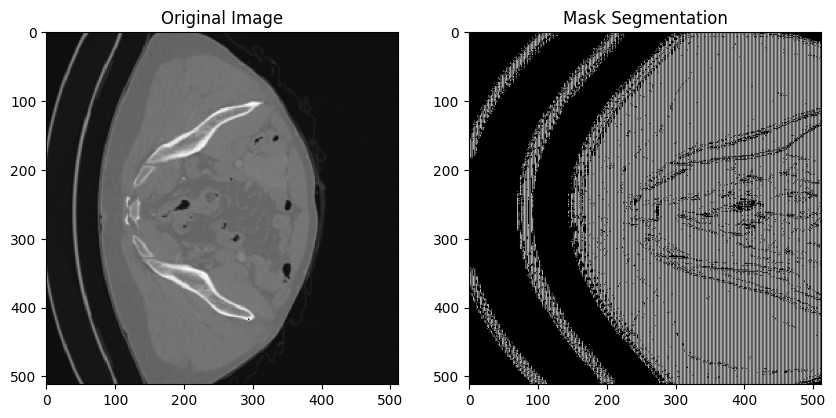

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(X_test[chosen_scan], cmap='gray')
ax1.set_title('Original Image')
ax2.imshow(mask_reshaped, cmap='gray')
ax2.set_title('Mask Segmentation')
plt.show()

We can't compute metrics because we don't have the ground truths of X_test :( 